In [277]:
!pip install trimesh
!pip install torch
import os
import trimesh
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [278]:
sydney_datast = keras.utils.get_file(
    "sydney-urban-objects-dataset.tar.gz",
    "http://www.acfr.usyd.edu.au/papers/data/sydney-urban-objects-dataset.tar.gz",
    extract=True
)
sydney_datast = os.path.join(os.path.dirname(sydney_datast), 'sydney-urban-objects-dataset')


In [279]:
print(sydney_datast)
import os
print(os.listdir('/root/.keras/datasets/sydney-urban-objects-dataset_extracted/sydney-urban-objects-dataset/objects'))

/root/.keras/datasets/sydney-urban-objects-dataset
['trunk.40.8444.csv', 'pedestrian.85.4093.csv', 'post.4.2446.bin', 'pedestrian.60.2299.csv', 'traffic_lights.35.8254.bin', 'traffic_lights.13.4868.bin', 'pedestrian.141.8254.bin.meta', '4wd.6.16217.bin', 'pedestrian.95.4868.bin', 'bus.5.2299.csv', 'pedestrian.137.8254.csv', 'post.5.2446.bin.meta', 'trunk.47.20631.bin', 'car.13.16217.bin', 'trunk.48.11204.csv', 'bus.2.6994.bin', 'bicycle.2.10974.bin.meta', 'car.41.17589.bin', 'car.32.5463.bin.meta', 'car.36.6994.bin', 'ute.14.20631.bin.meta', 'traffic_sign.31.270.csv', 'pole.11.25322.bin', 'bus.6.2299.csv', 'vegetation.0.5229.bin.meta', 'pedestrian.58.2299.csv', 'car.36.6994.bin.meta', 'car.86.12715.bin.meta', 'trunk.12.0.csv', 'pedestrian.88.4093.bin.meta', 'pedestrian.13.6994.bin.meta', 'traffic_sign.28.270.bin', 'van.5.25322.bin.meta', 'biker.3.19761.bin', 'pedestrian.145.8444.bin', 'pole.10.23124.bin', 'car.86.12715.csv', 'tree.9.17038.bin.meta', 'car.33.8254.bin.meta', 'pillar.13.8

In [280]:
def read_bin(file_name):

    names = ['t','intensity','id','x','y','z','azimuth','range','pid']

    formats = ['int64', 'uint8', 'uint8',
               'float32', 'float32', 'float32',
               'float32', 'float32', 'int32']

    binType = np.dtype( dict(names=names, formats=formats) )
    data = np.fromfile(file_name, binType)

    # 3D points, one per row
    P = np.vstack([ data['x'], data['y'], data['z'] ]).T

    return P

sample = read_bin('/root/.keras/datasets/sydney-urban-objects-dataset_extracted/sydney-urban-objects-dataset/objects/4wd.2.3582.bin')
print(sample.shape)

(204, 3)


In [281]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)
num_classes

26

In [282]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=k))
    pcs = res[:, 0:-1]
    labels = res[:, -1]
    labels -= 1
    return pcs, labels

class SydneyUrban(Dataset):
  def __init__(self, transform = False):
    self.files = []
    self.labels = []
    self.sample_size = 256

    folders = glob.glob('/root/.keras/datasets/sydney-urban-objects-dataset_extracted/sydney-urban-objects-dataset/objects')
    files = glob.glob(folders[0] + "/*")
    for file in files:
        file_name = file.split("/")[-1]
        if file_name.split(".")[-1] == "bin":
            label = file_name.split(".")[0]
            self.labels.append(labels_dict[label])
            self.files.append(file)

  def __len__(self):
      return len(self.files)

  def __getitem__(self, idx):
      pts_path = self.files[idx]
      label = self.labels[idx]

      pts = read_bin(pts_path)
      label = [label]*len(pts)
      label = np.array(label)

      pts, label = sub_sample(pts, label, self.sample_size)
      label = label[0] + 1  # now it stays in [0..25]
      return {'points': np.array(pts, dtype="float32"), 'labels': label.astype(int)}

In [283]:
from sklearn.model_selection import train_test_split
dataset = SydneyUrban()

train, test = train_test_split(dataset, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

print(len(dataset))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

631
13
4
4


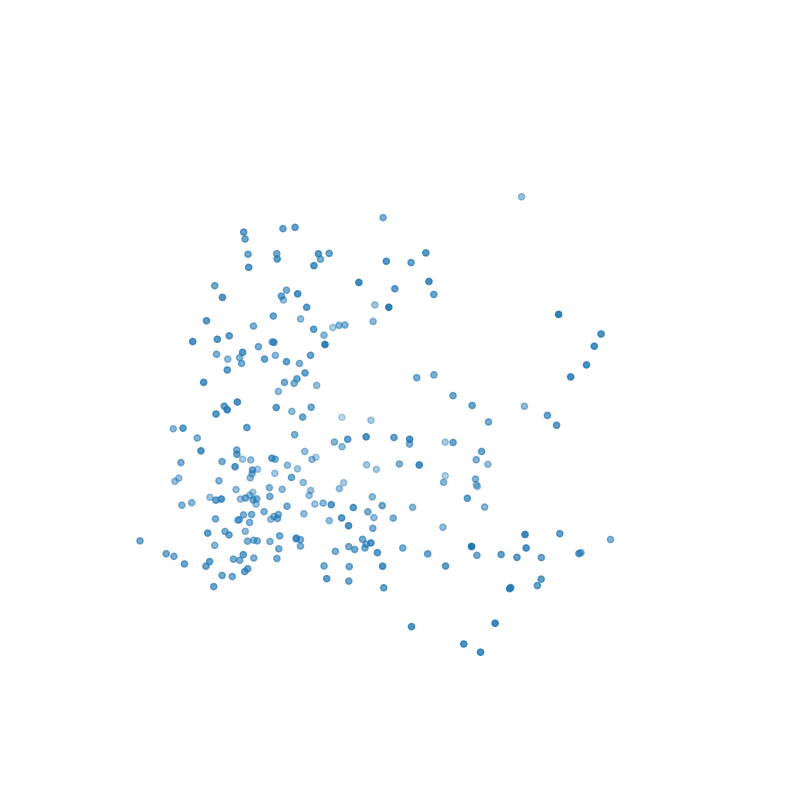

Data Shapes:  torch.Size([32, 256, 3]) torch.Size([32])


In [284]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[1]['points'][:, 0], dataset[1]['points'][:, 1], dataset[1]['points'][:, 2])
ax.set_axis_off()
plt.show()
print("Data Shapes: ", next(iter(train_loader))['points'].shape, next(iter(train_loader))['labels'].shape)


In [285]:
class TNet(nn.Module):
  def __init__(self, k = 3):
    super().__init__()
    self.k = k

    self.conv1 = nn.Conv1d(in_channels=k, out_channels=64, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=k*k)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)
    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    batch_size = x.size(0)

    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))

    pool = nn.MaxPool1d(x.size(-1))(x)
    flat = nn.Flatten(1)(pool)

    x = F.relu(self.bn4(self.fc1(flat)))
    x = F.relu(self.bn5(self.dropout(self.fc2(x))))
    x = self.fc3(self.dropout(x))

    iden = torch.eye(self.k, requires_grad=False).repeat(batch_size, 1, 1).to(x.device)
    x = x.view(-1, self.k, self.k)
    x = x + iden

    return x


In [286]:
class PointNet(nn.Module):
  def __init__(self, num_classes = 26):
    super().__init__()
    self.input_transform = TNet(k = 3)
    self.feature_transform = TNet(k = 64)

    self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)

    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)
    self.dropout = nn.Dropout(p=0.3)
    self.logsoftmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = x.transpose(1, 2)

    trans = self.input_transform(x)
    x = torch.matmul(trans, x)

    x = F.relu(self.bn1(self.conv1(x)))

    trans_feat = self.feature_transform(x)
    x = torch.matmul(trans_feat, x)


    x = F.relu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))


    pool = nn.MaxPool1d(x.size(-1))(x)
    flat = nn.Flatten(1)(pool)

    x = F.relu(self.bn4(self.fc1(flat)))
    x = F.relu(self.bn5(self.dropout(self.fc2(x))))
    x = self.fc3(self.dropout(x))

    return self.logsoftmax(x), trans, trans_feat

In [287]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=False).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=False).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [288]:
pointnet = PointNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pointnet.to(device)

PointNet(
  (input_transform): TNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=9, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (feature_transform): TNet(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(

In [289]:
def val(model, device, loss_fn, val_loader):
    model = model.to(device)
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            # 'data' is a dictionary with keys 'points' and 'labels'
            images = data['points'].to(device)
            labels = data['labels'].to(device)

            outputs, m3x3, m64x64 = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

In [290]:
def train(model, num_epochs, device):
    model = model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    train_risk = []
    val_risk = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0.0
        total_samples = 0

        for i, data in enumerate(train_loader):
            images = data['points'].to(device)
            labels = data['labels'].to(device)

            outputs, m3x3, m64x64 = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()



        # Calculate average training loss and accuracy over all samples
        avg_train_loss = total_loss / total_samples
        avg_train_accuracy = total_correct / total_samples

        # Evaluate on the validation set
        # (Assuming your 'val' function also uses total sample counts correctly)
        val_loss, val_acc = val(model, device, loss_function, val_loader)

        train_risk.append(avg_train_loss)
        train_accuracy.append(avg_train_accuracy)
        val_risk.append(val_loss)
        val_accuracy.append(val_acc)

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Risk: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
                  f"VAL Risk: {val_loss:.4f}, VAL Accuracy: {val_acc:.4f}")

    # Plot training and validation risk (loss)
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_risk, label='train')
    plt.plot(range(1, num_epochs+1), val_risk, label='val')
    plt.legend()
    plt.title('Train and Validation Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accuracy, label='train')
    plt.plot(range(1, num_epochs+1), val_accuracy, label='val')
    plt.legend()
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    return train_risk, val_risk, train_accuracy, val_accuracy

Epoch 2/100: Train Risk: 0.0850, Train Accuracy: 0.2630, VAL Risk: 0.0994, VAL Accuracy: 0.2871
Epoch 4/100: Train Risk: 0.0782, Train Accuracy: 0.2754, VAL Risk: 0.1013, VAL Accuracy: 0.3267
Epoch 6/100: Train Risk: 0.0753, Train Accuracy: 0.3052, VAL Risk: 0.0978, VAL Accuracy: 0.3366
Epoch 8/100: Train Risk: 0.0712, Train Accuracy: 0.3474, VAL Risk: 0.0778, VAL Accuracy: 0.3663
Epoch 10/100: Train Risk: 0.0645, Train Accuracy: 0.3350, VAL Risk: 0.0712, VAL Accuracy: 0.4158
Epoch 12/100: Train Risk: 0.0607, Train Accuracy: 0.4194, VAL Risk: 0.0695, VAL Accuracy: 0.3861
Epoch 14/100: Train Risk: 0.0539, Train Accuracy: 0.4814, VAL Risk: 0.0608, VAL Accuracy: 0.4554
Epoch 16/100: Train Risk: 0.0550, Train Accuracy: 0.4888, VAL Risk: 0.0642, VAL Accuracy: 0.4554
Epoch 18/100: Train Risk: 0.0536, Train Accuracy: 0.4715, VAL Risk: 0.0665, VAL Accuracy: 0.4257
Epoch 20/100: Train Risk: 0.0528, Train Accuracy: 0.4764, VAL Risk: 0.0567, VAL Accuracy: 0.4950
Epoch 22/100: Train Risk: 0.0485, 

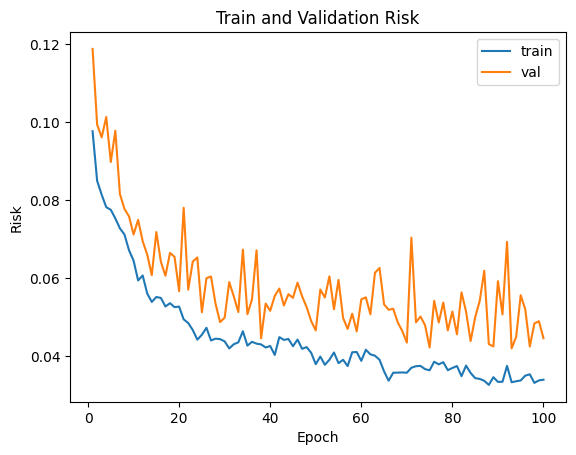

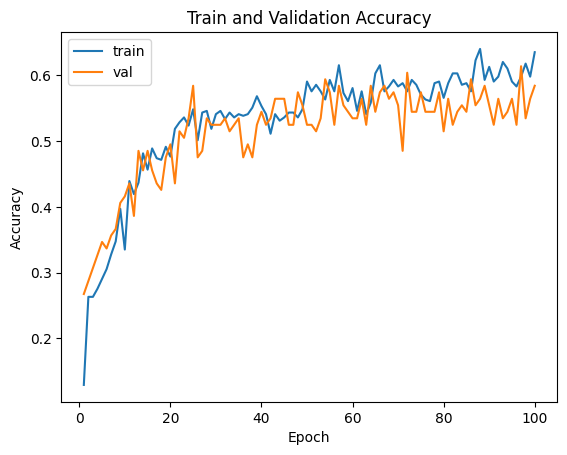

In [291]:
num_epochs = 100
train_risk, val_risk, train_accuracy, val_accuracy = train(pointnet, num_epochs, device)